# GNN Exploration

In [1]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)
print(parent)

d:\Documents\git\XAI-Cancer-Diagnosis


# ACQUIRE DATESET
The purpose of the below code is to construct the dataset for GNN. This involves taking BACH and: 1) Doing cell segmentation, 2) Construct the graphs. 
THe First step is very time consuming so the code below does the computation and saves it. THen we can do 2 seperatly at run time and have hyper parameters that vary how the graphs are constructed

In [2]:
# HOVERNET MODEL

from src.model.architectures.graph_construction.hover_net import HoVerNet
chkpt = "HoVerNet_MD-3.2.ckpt"
chkpt_path = os.path.join(parent,"experiments","checkpoints",chkpt)

# cell_seg_model = HoVerNet.load_from_checkpoint(chkpt_path, RESNET_SIZE=50,START_LR=0)

from src.datasets.BACH import BACH
src_folder = os.path.join(parent,"data","processed","BACH_TRAIN")
prc_folder = os.path.join(parent,"data","processed","BACH_TRAIN","INSTANCE_SEGMENTATION")

In [3]:
# DATA

from tqdm import tqdm
from PIL import Image
from src.transforms.graph_construction.hovernet_post_processing import *
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import adjust_sharpness

def generate_instance_masks(): # USE OF SHARPEN IS IMPORTANT TO CREATE MORE DISTINCTIVE CELLS
    """Takes all the BACH images and performs instance segmentation so that the graph constructors may be called later.
    """
    bach = BACH(src_folder, prc_folder, cell_seg_model, ids=[])

    img_transform = Compose(
                [ToTensor()]) #(lambda x: adjust_sharpness(x,20))])
    normalizer = Normalize((0.6441, 0.4474, 0.6039), (0.1892, 0.1922, 0.1535))
    for path in tqdm(bach.original_image_paths, desc="Creating Instance Segmentation from BACH"):
        img = Image.open(path)
        
        orig_img = img_transform(img)
        img = normalizer(orig_img.clone())
        
        ins_pred = instance_mask_prediction_hovernet(cell_seg_model, img, tile_size=128, pre_normalized=True)
        
        img = cut_img_from_tile(img, tile_size=128)
        orig_img = cut_img_from_tile(orig_img, tile_size=128)
        
        assert img.shape[1:] == ins_pred.shape[:]
        
        data = {"image": img, "instance_mask": ins_pred,"original_image": orig_img}
        file_name = os.path.basename(path)[:-4] + ".pt"
        proc_path = os.path.join(bach.instance_segmentation_dir, file_name)
        torch.save(data, proc_path)


In [4]:
#process()

In [5]:
# Make sure saved properly and loading properly
from src.vizualizations.cellseg_viz import instance_segmentation_vizualised
import matplotlib.pyplot as plt
import torch

sample = torch.load(os.path.join(prc_folder,"iv030.pt"))
if False:
    instance_segmentation_vizualised(sample["original_image"], sample["instance_mask"].squeeze(),figsize=(40,40))
    plt.show()

# Generate Graphs

In [6]:
from src.transforms.graph_construction.graph_extractor import extract_graph

src_folder = os.path.join(parent,"data","processed","BACH_TRAIN")
bach = BACH(src_folder,dmin=100,k=6,window_size=64,downsample=2) #10 for k seems to high, maybe 5 would be better
# bach.generate_graphs(num_workers=5)

### Generate the distribution

In [7]:
#dist = bach.generate_node_distribution()
# print(dist)

# Challenging Images:
After running the instance segmentation and then graph generation, there were some images that produced graphs with no nodes. They were:
- b067
- n026
- n045

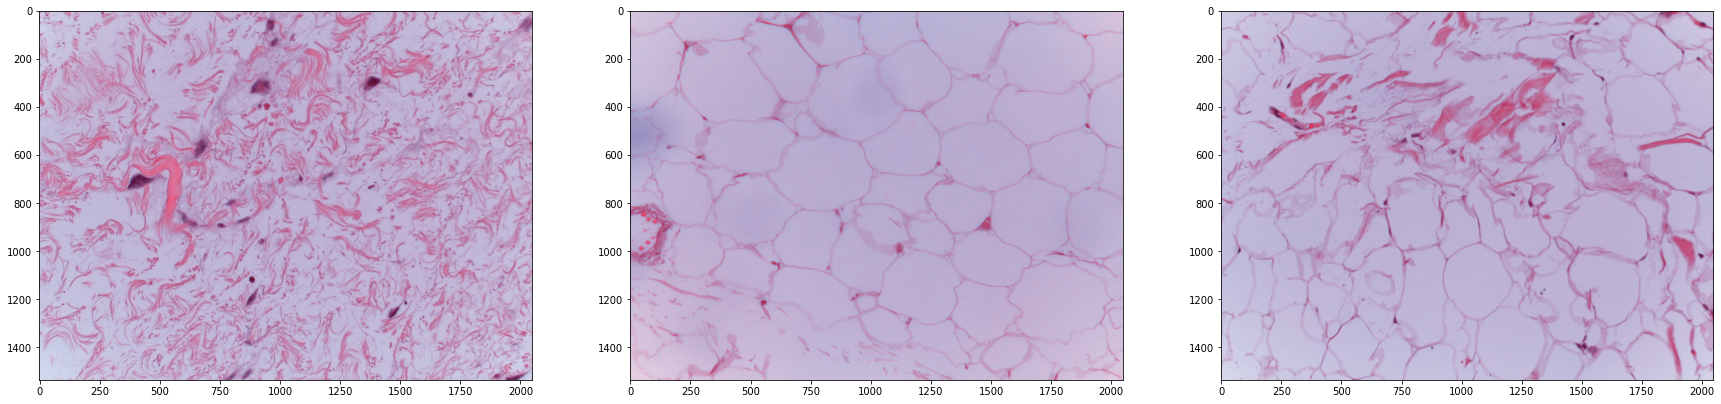

In [8]:
bad_img_pth = [os.path.join(src_folder,"Benign","b067.tif"),os.path.join(src_folder,"Normal","n026.tif"),os.path.join(src_folder,"Normal","n045.tif")]
bad_images = [Image.open(pth) for pth in bad_img_pth]

f,ax = plt.subplots(1,len(bad_images),figsize=(30,30*len(bad_images)))
for i in range(len(bad_images)):
    ax[i].imshow(bad_images[i])
plt.show()

# Results

(1408, 1920)


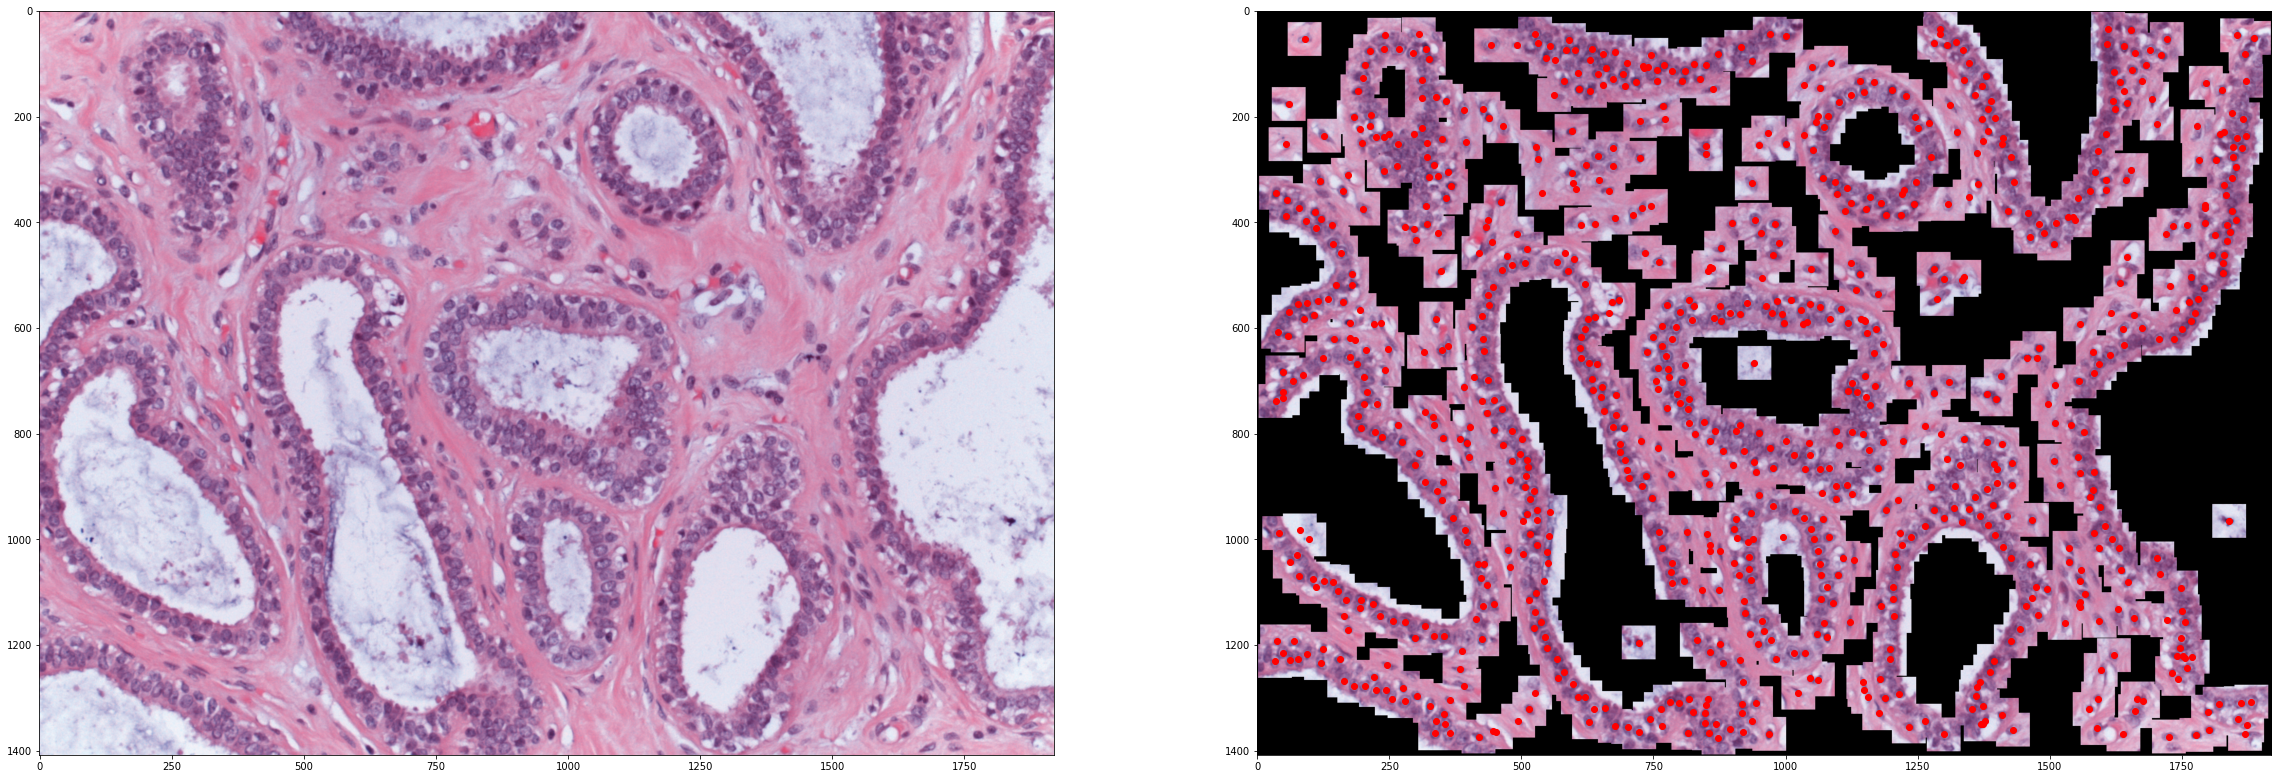

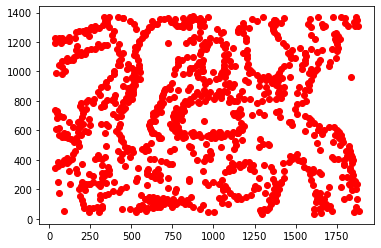

In [45]:
from src.utilities.img_utilities import tensor_to_numpy
from src.vizualizations.image_viz import plot_images
from torchvision.transforms.functional import resize

def visualize_graph(bach:BACH,id,upsample=2):
    graph,ins_seg = bach.get_graph_seg_pair(id)
    dimensions = tuple(ins_seg['image'].shape[1:])
    print(dimensions)
    final = torch.zeros(3,*dimensions)
    for i,cell in enumerate(graph.x):
        pixels = len(cell)
        n_shape = (3,int((pixels//3)**0.5),int((pixels//3)**0.5))
        img = cell.unflatten(0,n_shape)
        img_n_dim = tuple(torch.as_tensor(img.shape[1:])*upsample)
        img = resize(img,size=img_n_dim)
        wd,ht = tuple(img.shape[1:])
        x,y = tuple(graph.pos[i])
        row,col = int(y.item()),int(x.item())
        
        final[:,row-ht//2:row+ht//2,col-wd//2:col+wd//2] = 1
    
    f,ax = plt.subplots(2,1,figsize=(50,20))
    ax[0].imshow(tensor_to_numpy(ins_seg['original_image']))
    ax[1].imshow(tensor_to_numpy(final*ins_seg['original_image']))
    ax[1].scatter(graph.pos[:,0],graph.pos[:,1],c="r")
    plt.show()

visualize_graph(bach,id=20)

# GNN

In [10]:
#from src.model.trainers.gnn_trainer import GNNTrainer
#import json
#
#args = json.load(open(os.path.join(parent,"experiments", "args", "default.json")))
#
#GNNTrainer(args).train()